# Homework 1 - Data Wrangling with Hadoop

The goal of this assignment is to put into action the data wrangling techniques from the exercises of week-3 and week-4. We highly suggest you to finish these two exercises first and then start the homework. In this homework, we are going to reuse the same __sbb__ dataset as we see in two exercises. 

Try to use as much as HiveQL as possible and use pandas operations only when it's necessary.

__Hand-in:__
- __Due: 24.03.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your queries readable


__Cluster Usage__

As there are many of you working with the cluster, we encourage you to prototype your queries on small data samples before running them on whole datasets.

__Documentation__

Hive queries: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select>

Hive functions: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF>


In [3]:
import os
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

from pyhive import hive
username = os.environ['JUPYTERHUB_USER']
# create connection
conn = hive.connect(host='iccluster059.iccluster.epfl.ch', port=10000, username=username) 
# create cursor
cur = conn.cursor()

## Data from SBB/CFF/FFS

Data source: <https://opentransportdata.swiss/en/dataset/istdaten>

In this part, you will leverage Hive to perform exploratory analysis of data published by the [Open Data Platform Swiss Public Transport](https://opentransportdata.swiss).

Format: the dataset is originally presented as a collection of textfiles with fields separated by ';' (semi-colon). For efficiency, the textfiles have been compressed into Optimized Row Columnar ([ORC](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+ORC)) file format. 

Location: you can find the data in ORC format on HDFS at the path `/data/sbb/orc/istdaten`.

The full description from opentransportdata.swiss can be found in <https://opentransportdata.swiss/de/cookbook/ist-daten/> in four languages. Because of the translation typos there may be some misunderstandings. We suggest you rely on the German version and use an automated translator when necessary. We will clarify if there is still anything unclear in class and Slack. Here are the relevant column descriptions:

- `BETRIEBSTAG`: date of the trip
- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `HALTESTELLEN_NAME`: name of the stop
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `AN_PROGNOSE`: actual arrival time
- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `AB_PROGNOSE`: actual departure time
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

Each line of the file represents a stop and contains arrival and departure times. When the stop is the start or end of a journey, the corresponding columns will be empty (`ANKUNFTSZEIT`/`ABFAHRTSZEIT`).

In some cases, the actual times were not measured so the `AN_PROGNOSE_STATUS`/`AB_PROGNOSE_STATUS` will be empty or set to `PROGNOSE` and `AN_PROGNOSE`/`AB_PROGNOSE` will be empty.

### Get yourself ready

If you have gone through the exercises by yourself, you are free to go for the questions. If you haven't gone through the exercises, you can follow the next two cells to get all your databases and tables ready.

__In Shell__:

```bash
hdfs dfs -mkdir   -p                              /user/${JUPYTERHUB_USER}/hive

hdfs dfs -setfacl -m    user:hive:r-x             /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m group::r-x                /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m other::---                /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m default:group::r-x        /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m default:other::---        /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -m    user:hive:rwx             /user/${JUPYTERHUB_USER}/hive

hdfs dfs -setfacl -m    default:user:hive:rwx     /user/${JUPYTERHUB_USER}/hive
```

__In Python__:
```python
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

# Drop the table of one day
query = """
    drop table if exists {0}.sbb_05_11_2018
""".format(username)
cur.execute(query)

# Create the table of one day
query = """
    create table {0}.sbb_05_11_2018
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2018'
""".format(username)
cur.execute(query)
```

**Database creation:**

In [2]:
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

### Question I.a - 5 Points

In the exercise, you were asked to find how many stops of each type of transportation for the date 05.11.2018. Now, let's do the same for the whole dataset. 

Show the results with a stacked bar chart (you can use `pandas` to create a pivot table if necessary). Document any patterns you can see.

__Hint__: 
- To properly order by date, you may have to parse them using the `unix_timestamp` function.
- When using `pd.read_sql(query, conn, ...)` to retrieve the query results, there is one `parse_dates` argument for date parsing.
- If you think it is not nice to display all the data in one plot, you can select a small period of data, i.e. 3 months, for visualization to detect the pattern.

In [3]:
"""
We're only working on three months 01/2018, 02/2018 and 03/2018 as pointed out by the hint and because of memory limitations
"""

query = """
    select BETRIEBSTAG as dates,
           coalesce(NULLIF(lower(PRODUKT_ID),''),'unspecified') as ttype,
           count(*) as stops
    from {0}.sbb_orc
    where BETRIEBSTAG like '%01_2018' or BETRIEBSTAG like '%02_2018' or BETRIEBSTAG like '%03_2018'
    group by BETRIEBSTAG, lower(PRODUKT_ID)
    order by unix_timestamp(BETRIEBSTAG, 'dd.MM.yyy')
""".format(username)
df_type = pd.read_sql(query, conn, parse_dates = {'dates' : '%d.%m.%Y'}) #change to all dates instead of where BETRIEBSTAG like '%01_2018' or BETRIEBSTAG like '%02_2019'

In [4]:
new_df = df_type.copy()

In [5]:
new_df=new_df.pivot(index = 'dates',columns = 'ttype').sort_values(by = 'dates') # we index on the dates to display

In [6]:
new_df.index = new_df.index.astype(str)

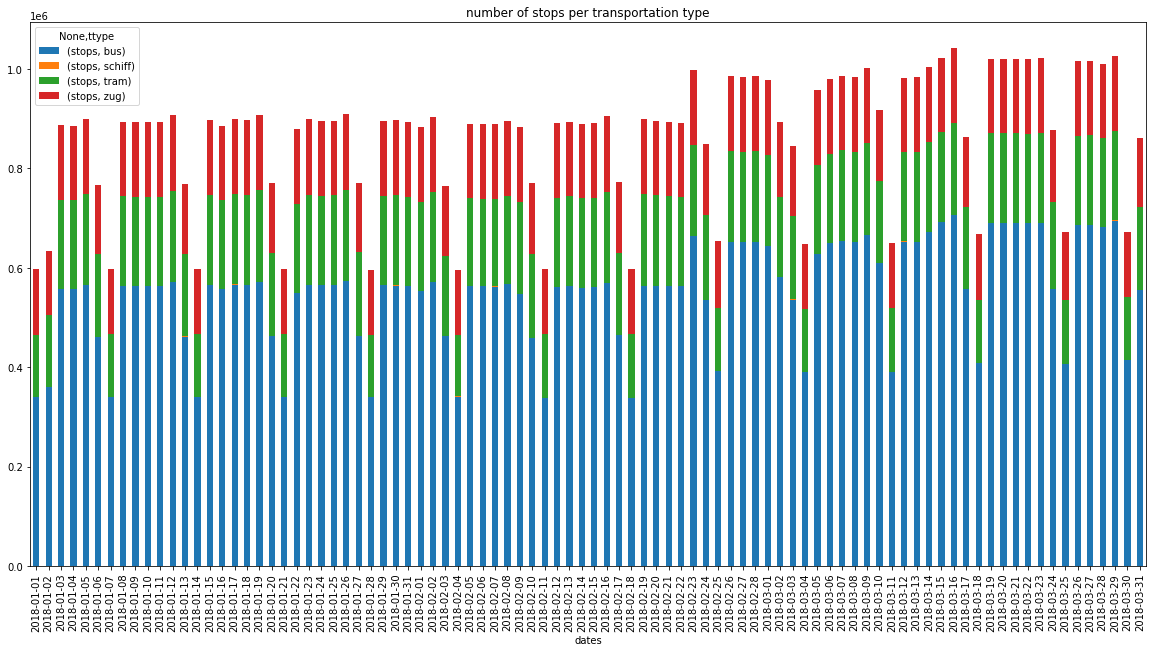

In [7]:
plt.rcParams["figure.figsize"] = [20, 10]
fig = new_df.plot.bar(stacked=True)
fig.set_title("number of stops per transportation type")
plt.show()

***Observations:***

**we can see a seasonal/periodic change in the number of stops. This can be explained by the fact that the service decreases on the weekends or holidays.** (*i.e. 01.01.2018 is a holiday and 06.01.2018 and 07.01.2018 is a weekend.*)
**The change is consistent throughout the whole periode of the 3 months we took**





### Question I.b - 10 Points

Get the set of IC (`VERKEHRSMITTEL_TEXT`) trains you can take to go (without connections) from Genève to Lausanne on a typical week day (not Saturday, not Sunday, not a bank holiday). Display the train number (`LINIEN_ID`) as well as the schedule of the trains.

__Note:__ do not hesitate to create intermediary tables. You can use the advanced search of SBB's website to check your answer, the schedule of IC from Genève to Lausanne has not changed.

In [9]:
query = """
    drop table if exists {0}.ic_lausanne
""".format(username)
cur.execute(query)

"""
The ic_lausanne table represents all the trains that are departing from lausanne. (we took betriebstag = 01.2018 for memory limitations)

"""

query = """
    create table {0}.ic_lausanne
    stored as ORC
    as
    select  LINIEN_ID as line_id,
            BETRIEBSTAG as dates,
            HALTESTELLEN_NAME as stops,
            ANKUNFTSZEIT as arrival_t,
            VERKEHRSMITTEL_TEXT as stype,
            AB_PROGNOSE
    from {0}.sbb_orc
    where BETRIEBSTAG like '%01_2018' and VERKEHRSMITTEL_TEXT = 'IC' and lower(HALTESTELLEN_NAME) = 'lausanne' and NULLIF(lower(ANKUNFTSZEIT),'') IS NOT NULL
""".format(username)
cur.execute(query)

In [10]:
query = """
    drop table if exists {0}.ic_geneva
""".format(username)
cur.execute(query)

query = """
    create table {0}.ic_geneva
    stored as ORC
    as
    select  LINIEN_ID as line_id,
            BETRIEBSTAG as dates,
            HALTESTELLEN_NAME as stops,
            ABFAHRTSZEIT as departure_t,
            VERKEHRSMITTEL_TEXT as stype
    from {0}.sbb_orc
    where BETRIEBSTAG like '%01_2018' and VERKEHRSMITTEL_TEXT = 'IC' and lower(HALTESTELLEN_NAME) = 'genève' and NULLIF(lower(ABFAHRTSZEIT),'') IS NOT NULL
""".format(username)
cur.execute(query)

Let's select the train lines that go by geneve and lausanne. For the moment I don't do dinstinction between those that from lausanne to geneve and the reverse.

In [15]:
 query = """
    drop table if exists {0}.ic_direct
""".format(username)
cur.execute(query)

query = """
    create table {0}.ic_direct
    stored as ORC
    as
    select  distinct ic_geneva.line_id as line_id,
            DATE_FORMAT(FROM_UNIXTIME(unix_timestamp(departure_t, 'dd.MM.yyyy HH:mm')), 'HH:mm') as departure,
            DATE_FORMAT(FROM_UNIXTIME(unix_timestamp(arrival_t, 'dd.MM.yyyy HH:mm')), 'HH:mm') as arrival
    from {0}.ic_geneva inner join {0}.ic_lausanne on ic_geneva.line_id =  ic_lausanne.line_id and ic_geneva.dates =  ic_lausanne.dates
    where unix_timestamp(departure_t, 'dd.MM.yyyy HH:mm') < unix_timestamp(arrival_t, 'dd.MM.yyyy HH:mm')
""".format(username)
cur.execute(query)

In [16]:
query = """
    select distinct * from {0}.ic_direct
""".format(username)
df_geneve = pd.read_sql(query, conn)
df_geneve

,ic_direct.line_id,ic_direct.departure,ic_direct.arrival
0,707,05:42,06:18
1,70731,17:42,18:18
2,709,06:42,07:18
3,711,07:42,08:18
4,715,09:42,10:18
5,719,11:42,12:18
6,721,12:42,13:18
7,727,15:42,16:18
8,729,16:42,17:18
9,731,17:42,18:18


### Question I.c - 10 Points

In the exercise, we discussed a little bit about two interesting status, `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`. We will continue here to see how things evolved in the past two years.

i) Please show us how the monthly distribution of `AN_PROGNOSE_STATUS` (arrival forcast status) for __IC 733__ train at the Lausanne station changes over time, i.e., how many of them are REAL, GESCHAETZT, etc. in every month. Use `pandas` to create a pivot table if necessary.

In [17]:
query = """
    drop table if exists {0}.ic_733
""".format(username)
cur.execute(query)

query="""
    create table {0}.ic_733
    stored as ORC
    as
    select * from {0}.sbb_orc
    where LINIEN_ID = 733 and VERKEHRSMITTEL_TEXT = "IC" and haltestellen_name = "Lausanne"
""".format(username)
cur.execute(query)

In [18]:
query = """
    with Times as(
        select substr(BETRIEBSTAG,4,8) as month, AN_PROGNOSE_STATUS as status
        from {0}.ic_733
    )
    select month, status as arr_status, count(*) as count
    from Times
    group by month, status
    order by unix_timestamp(month, 'MM.yyyy') asc
""".format(username)
df_arr = pd.read_sql(query, conn, parse_dates = { 'month' : '%m.%Y'})

In [19]:
df_arr_new= df_arr.set_index('month')

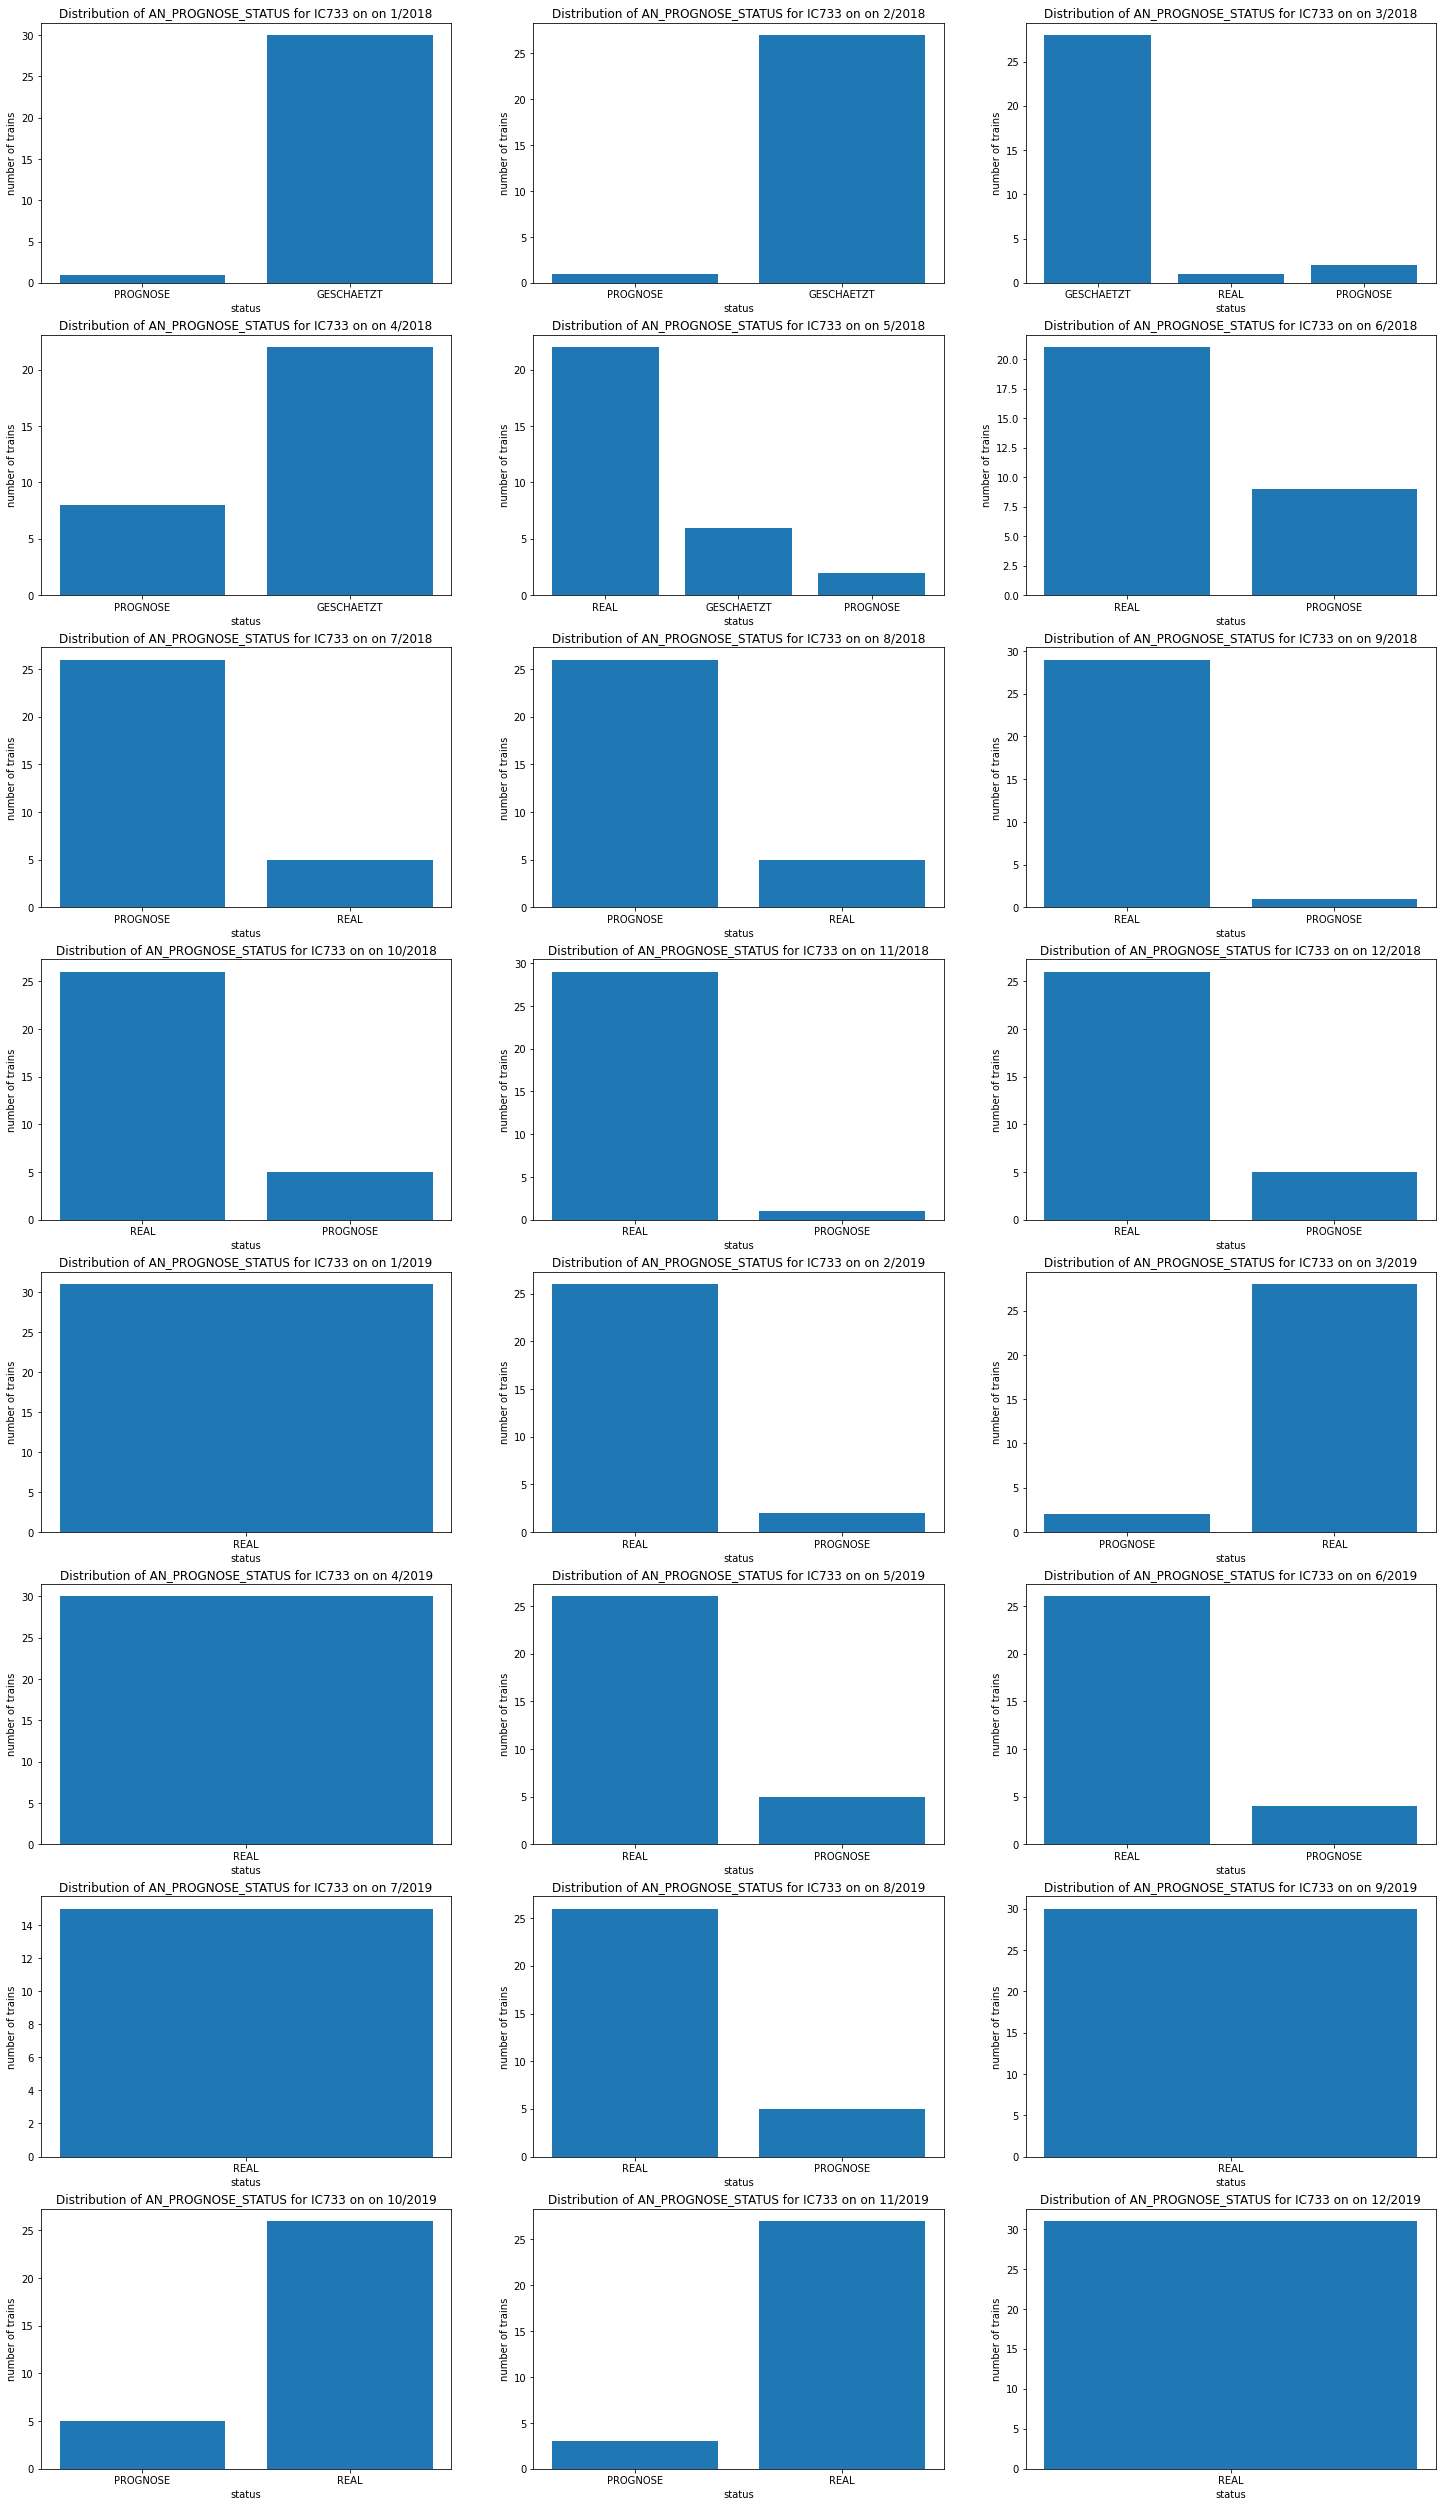

In [20]:
ld = list(set(df_arr_new.index))
ld.sort()
fig, axs = plt.subplots(8,3,figsize=(25,45))

indexes = [(x,y) for x in range(8) for y in range(3)]
for date, (x,y) in zip(ld, indexes):
    inter_df = df_arr_new.loc[date]
    axs[x][y].bar(inter_df['arr_status'],inter_df['count'])
    axs[x][y].set_title('Distribution of AN_PROGNOSE_STATUS for IC733 on on {}/{}'.format(date.month,date.year))
    axs[x][y].set_xticks(inter_df['arr_status'])
    axs[x][y].set_xlabel('status')
    axs[x][y].set_ylabel('number of trains')
plt.show()


ii) Show how the monthly distribution of `AN_PROGNOSE_STATUS` for all the trains that arrived at Lausanne station. Document any anything you observed.

In [16]:
query = """
    with Times as(
        select substr(BETRIEBSTAG,4,8) as month, AN_PROGNOSE_STATUS as status
        from {0}.sbb_orc
        where haltestellen_name = "Lausanne"
    )
    select month, status as arr_status, count(*) as count
    from Times
    group by month, status
    order by unix_timestamp(month, 'MM.yyyy') asc
""".format(username)
df_arr_all = pd.read_sql(query, conn , parse_dates = { 'month' : '%m.%Y'})

In [17]:
df_arr_all = df_arr_all.set_index('month')

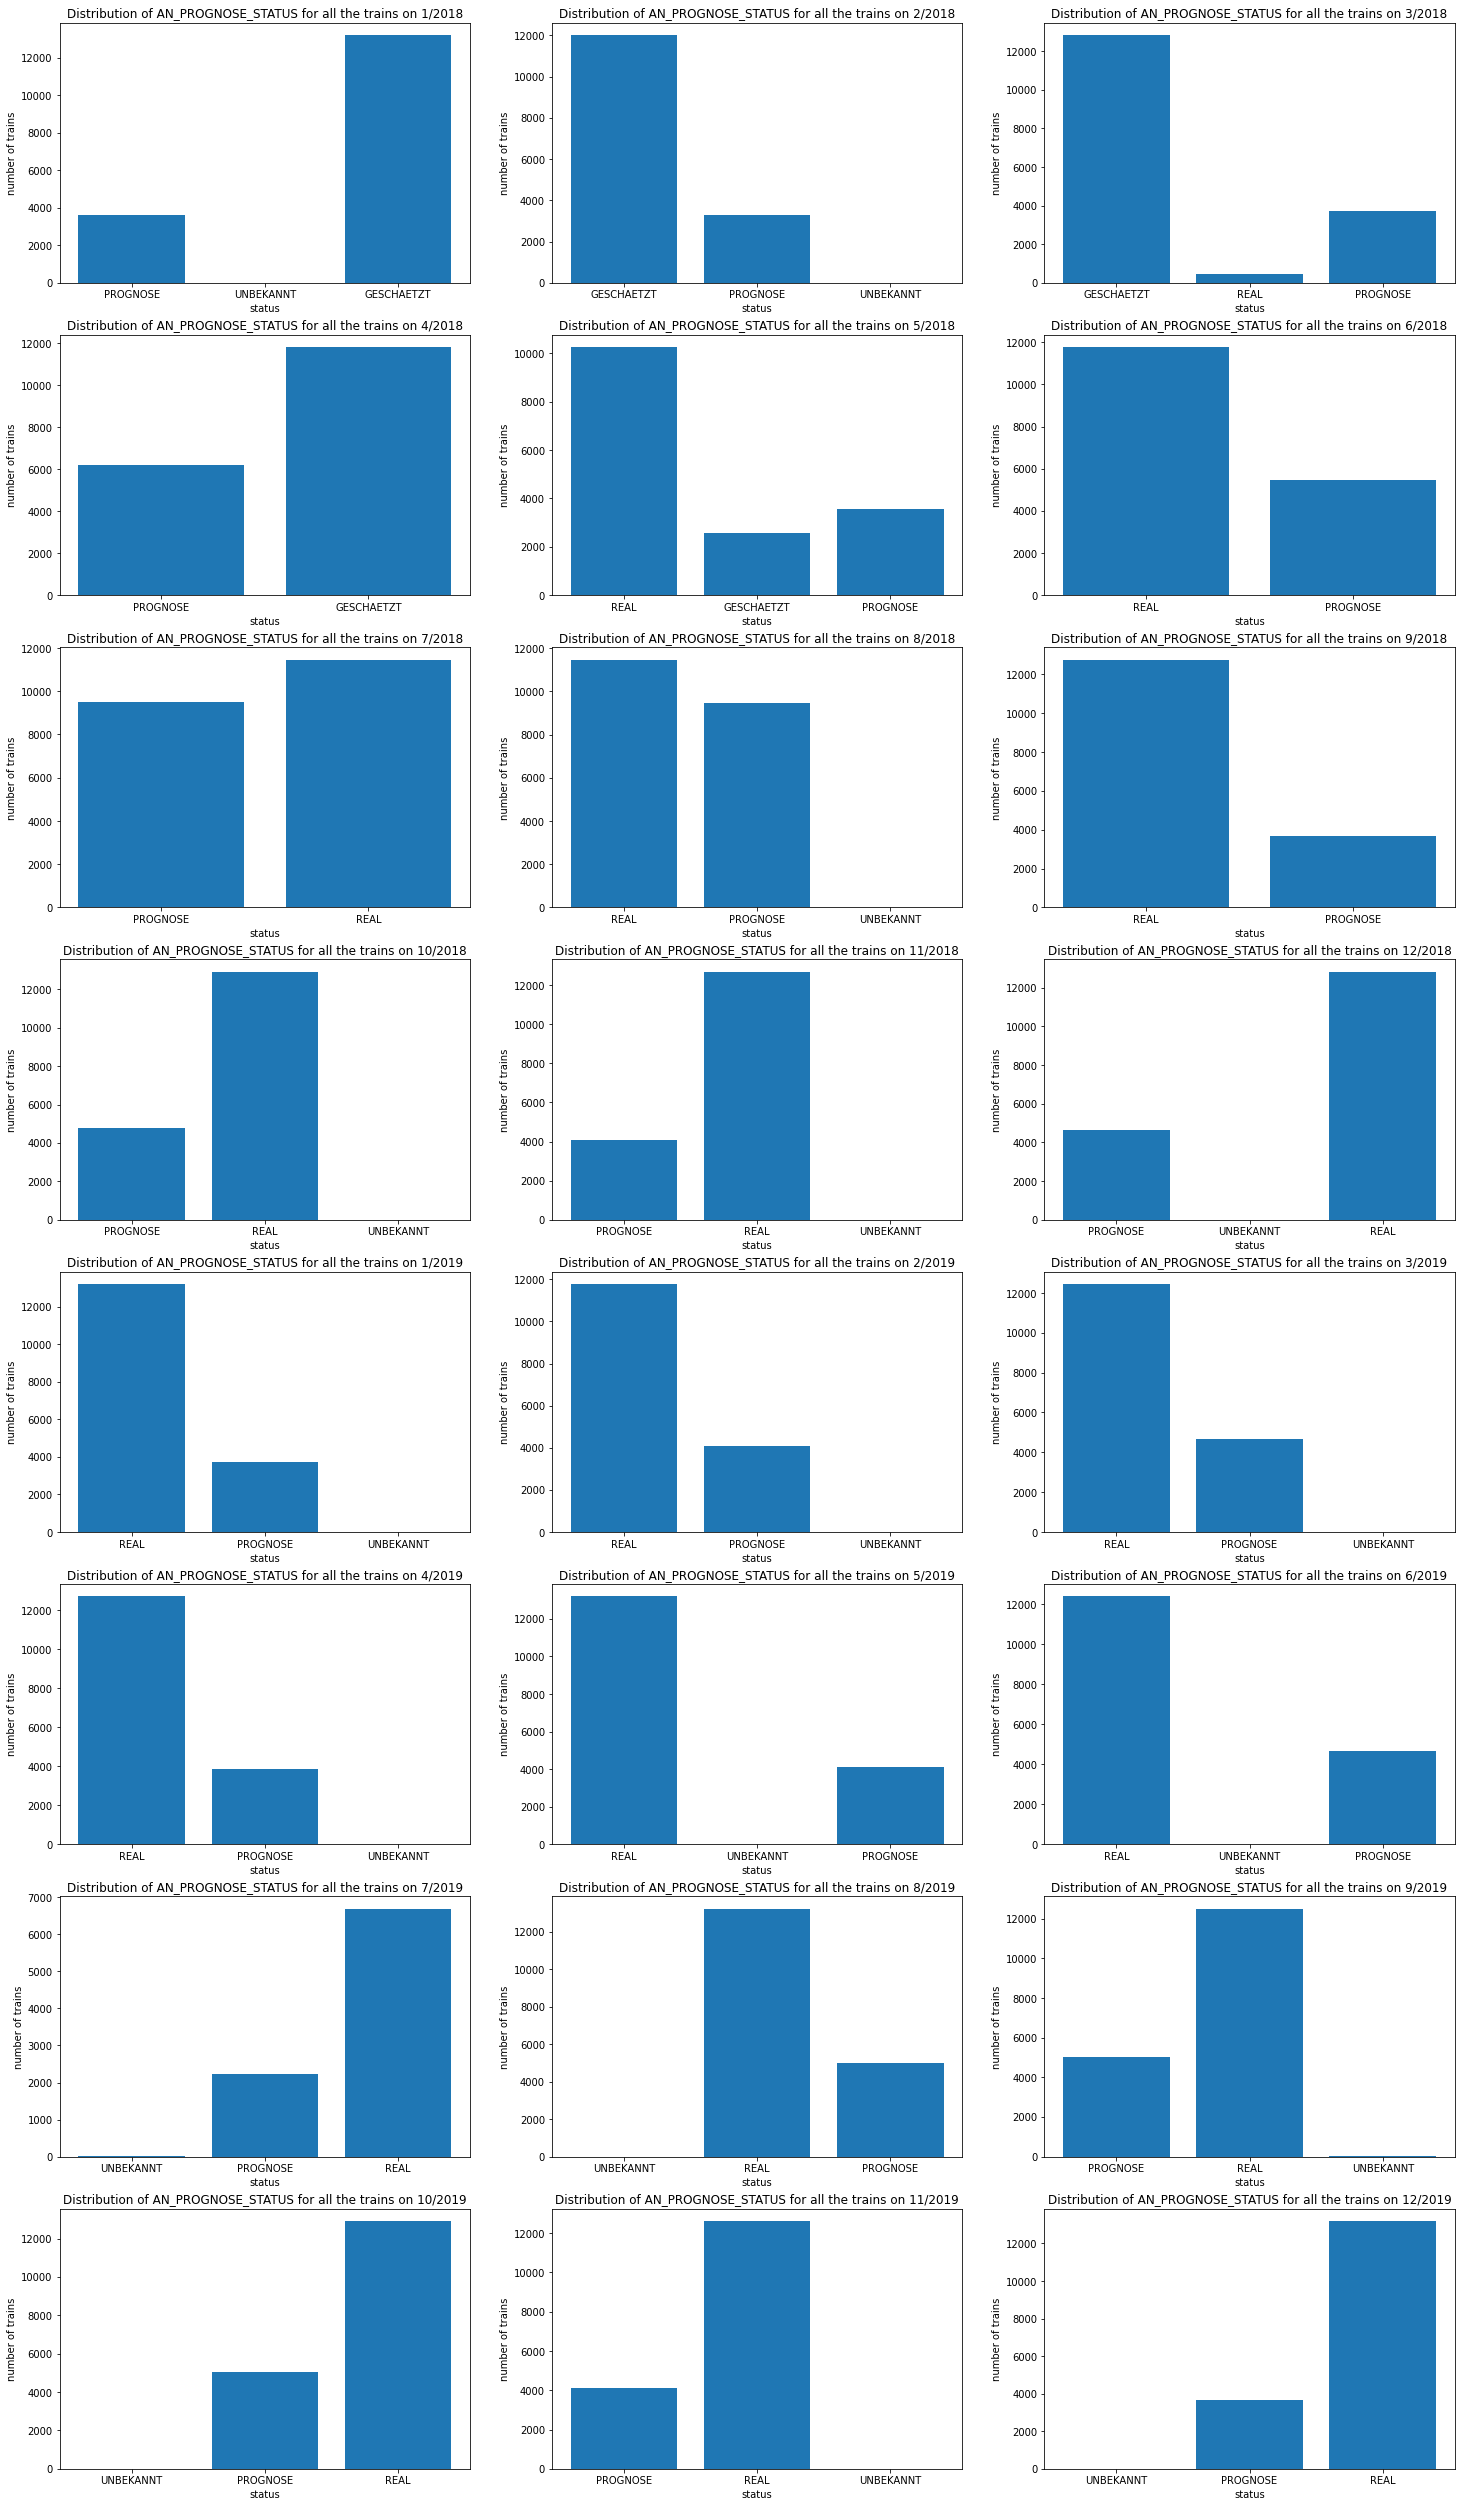

In [18]:
fig, axs = plt.subplots(8,3,figsize=(25,45))
indexes = [(x,y) for x in range(8) for y in range(3)]
for date, (x,y) in zip(ld, indexes):
    inter_df = df_arr_all.loc[date]
    axs[x][y].bar(inter_df['arr_status'],inter_df['count'])
    axs[x][y].set_title('Distribution of AN_PROGNOSE_STATUS for all the trains on {}/{}'.format(date.month,date.year))
    axs[x][y].set_xlabel('status')
    axs[x][y].set_ylabel('number of trains')
plt.show()

### Question I.d - 20 Points

In this question, use __REAL__ for `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`.

i) Display the distribution of delays for the __IC 733__ train at the Lausanne train station. Select the information from the database as a "histogram" with bin size of one minute and plot it in a proper way.

__Note:__ when the train is ahead of schedule, count this as a delay of 0.

***For creating histograms of bin size of 1 min, we will do queries that group by the number of trains in each delay category in minutes.***

**Arrival delays:**

In [22]:
query="""
    with Times as(
        select unix_timestamp(ankunftszeit, 'dd.MM.yyyy HH:mm') as expected, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yyyy HH:mm:ss') as actual
        from {0}.ic_733
        where lower(AN_PROGNOSE_STATUS) like 'real' and ankunftszeit != ''
    )
    select minute(from_unixtime( greatest(actual - expected, 0))) as delay, count(*) as number_trains
    from Times
    group by minute(from_unixtime( greatest(actual - expected, 0)))
    order by delay
""".format(username)
df_ic733_a = pd.read_sql(query, conn)

In [23]:
df_ic733_a = df_ic733_a.set_index('delay')

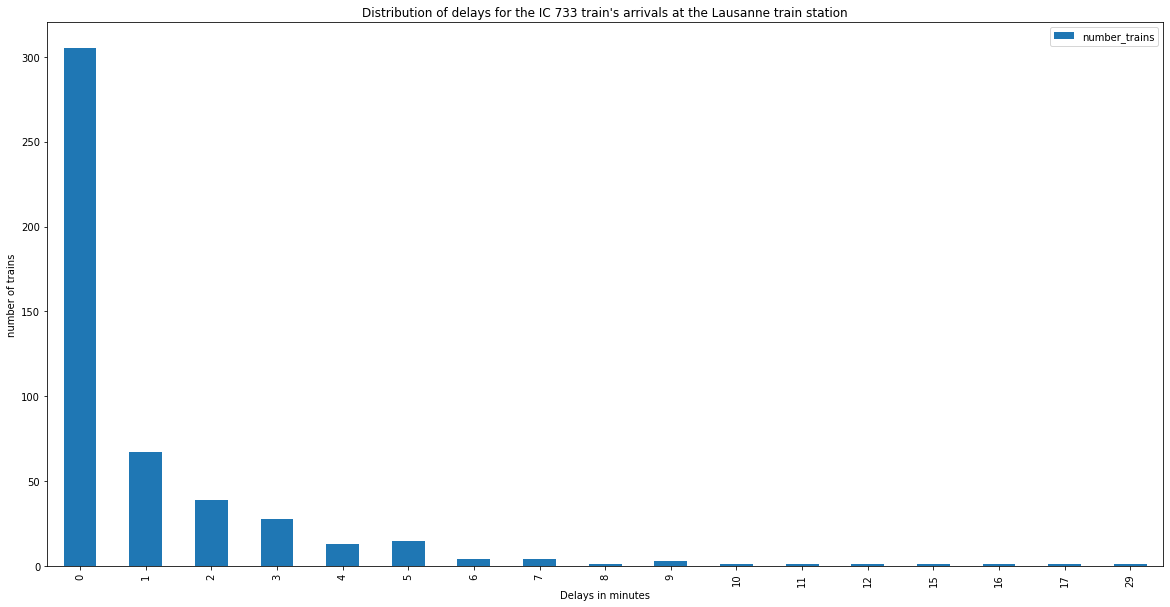

In [24]:
plt.rcParams["figure.figsize"] = [20, 10]
fig = df_ic733_a.plot.bar(stacked = True)
fig.set_title('Distribution of delays for the IC 733 train\'s arrivals at the Lausanne train station')
fig.set_ylabel('number of trains')
fig.set_xlabel('Delays in minutes')
plt.show()

**Departure delays:**

In [25]:
query="""
    with Times as(
        select unix_timestamp(abfahrtszeit, 'dd.MM.yyyy HH:mm') as expected, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyyy HH:mm:ss') as actual
        from {0}.ic_733
        where lower(AB_PROGNOSE_STATUS) like 'real'
    )
    select minute(from_unixtime( greatest(actual - expected, 0))) as delay, count(*) as number_trains
    from Times
    where actual > expected
    group by minute(from_unixtime( greatest(actual - expected, 0)))
    order by delay
""".format(username)
df_ic733_d = pd.read_sql(query, conn)

In [26]:
df_ic733_d = df_ic733_d.set_index('delay')

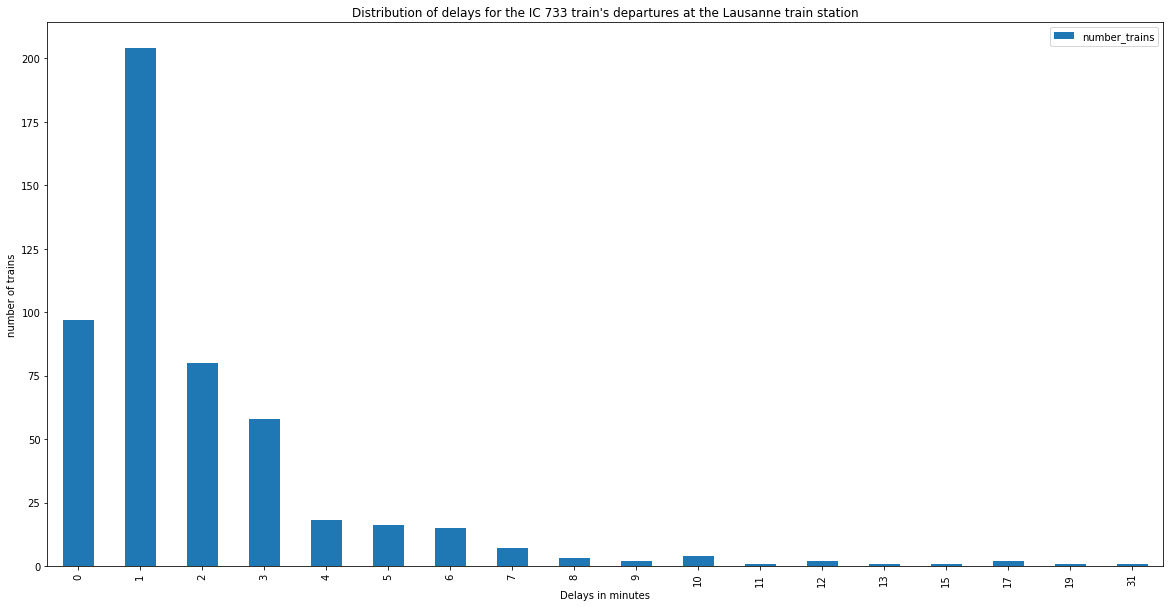

In [27]:
fig = df_ic733_d.plot.bar(stacked = True)
fig.set_title('Distribution of delays for the IC 733 train\'s departures at the Lausanne train station')
fig.set_ylabel('number of trains')
fig.set_xlabel('Delays in minutes')
plt.show()

ii) Compute the 50th and 75th percentiles of delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station. Which trains are the most disrupted? Can you find the tendency and interpret?

In [36]:
 query="""
    with Times as(
        select unix_timestamp(abfahrtszeit, 'dd.MM.yyyy HH:mm') as expected, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyyy HH:mm:ss') as actual,
               LINIEN_ID
        from {0}.sbb_orc
        where VERKEHRSMITTEL_TEXT = "IC" and lower(haltestellen_name) = "genève" and LINIEN_ID > 700 and LINIEN_ID < 731 and mod(LINIEN_ID,2) = 0
    ),
    delays as (
    select LINIEN_ID as id, minute(from_unixtime( greatest(actual - expected, 0))) as delay
    from Times
    where actual > expected )
    
    select id, percentile(delay , 0.5) as p_05, percentile(delay ,0.75) as p_075 , percentile(delay ,0.9) as p_09
    from delays
    group by id
""".format(username)
percentiles = pd.read_sql(query, conn)

In [37]:
percentiles

,id,p_05,p_075,p_09
0,702,1.0,1.0,3.0
1,706,1.0,2.5,5.0
2,710,1.0,2.0,4.0
3,716,1.0,2.0,4.0
4,724,1.0,2.0,4.0
5,704,1.0,3.0,4.0
6,708,1.0,3.0,6.0
7,712,1.0,2.0,3.0
8,714,1.0,2.0,4.0
9,718,1.0,1.0,3.0


**The data has a median of 1 minute, but this doesn't help up to descriminate between the lines. Looking at 75th percentile we can see that only two lines have 3.0 minutes. To further see which lines are more disrupted we take a look at the 90th percentile. It turns out that line 708 is the most disrupted.**

In [38]:
query="""
    with Times as(
        select unix_timestamp(abfahrtszeit, 'dd.MM.yyyy HH:mm') as expected, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyyy HH:mm:ss') as actual,
               LINIEN_ID
        from {0}.sbb_orc
        where VERKEHRSMITTEL_TEXT = "IC" and lower(haltestellen_name) = "genève" and LINIEN_ID > 700 and LINIEN_ID < 731 and mod(LINIEN_ID,2) = 0
    )
    select LINIEN_ID, minute(from_unixtime( greatest(actual - expected, 0))) as delay
    from Times
    where actual > expected
""".format(username)
df_1 = pd.read_sql(query, conn)

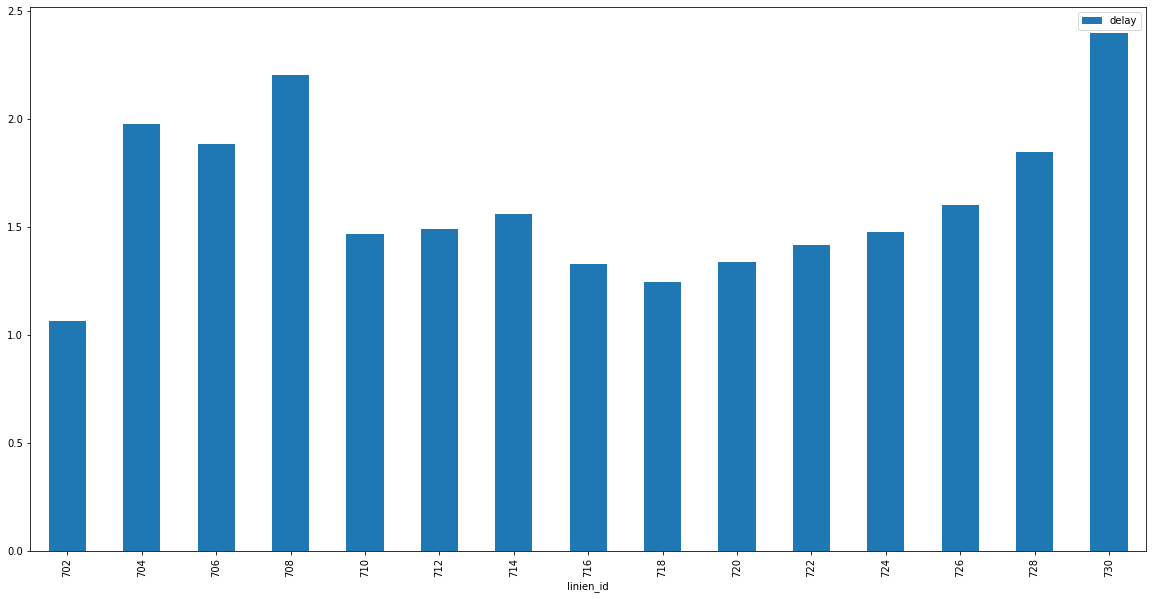

In [94]:
plt.rcParams["figure.figsize"] = [20, 10]
fig = df_1.groupby('linien_id').mean().plot.bar()

**This confirms our intuition about the disruption of IC708 if we take into acount that line 730 had an outlier of big magnitude which affected its mean.**

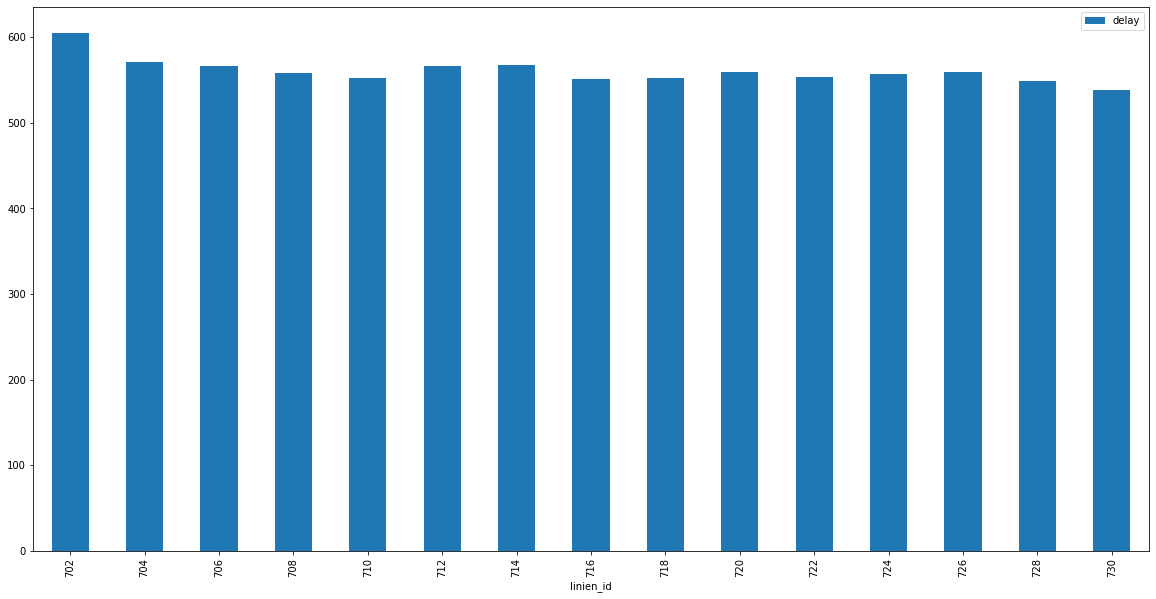

In [95]:
fig = df_1.groupby('linien_id').count().plot.bar()

**We can see from the plots that the line 730 has on average the largest delay whereas for the number of times the train got delayed the line 702 has the largest count**

iii) Compute 25th, 50th and 75th percentiles of delays for all trains departing Lausanne gare within each hour and visualize your results. Can you find the tendency and interpret?

In [41]:
query = """
    with Times as (
                    select unix_timestamp(abfahrtszeit, 'dd.MM.yyyy HH:mm') as expected, 
                            unix_timestamp(AB_PROGNOSE, 'dd.MM.yyyy HH:mm:ss') as actual
                    from {0}.sbb_orc
                    where lower(PRODUKT_ID) like 'zug' and lower(haltestellen_name) = "lausanne" 
    ),
    delays as (
            select minute(from_unixtime( greatest(actual - expected, 0))) as delay,
                   hour(from_unixtime(expected)) as hours
            from Times
            where actual > expected
    )
    
    select  hours, 
            percentile(delay , 0.25) as p_025, 
            percentile(delay ,0.5) as p_05, 
            percentile(delay ,0.75) as p_075
    from delays
    group by hours
    order by hours
""".format(username)
df_lausanne_delays = pd.read_sql(query, conn)

In [42]:
df_lausanne_delays = df_lausanne_delays.set_index('hours')
df_lausanne_delays

,p_025,p_05,p_075
hours,,,
0,0.0,1.0,3.0
1,0.0,1.0,3.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,1.0,1.0
7,0.0,1.0,2.0
8,0.0,1.0,2.0


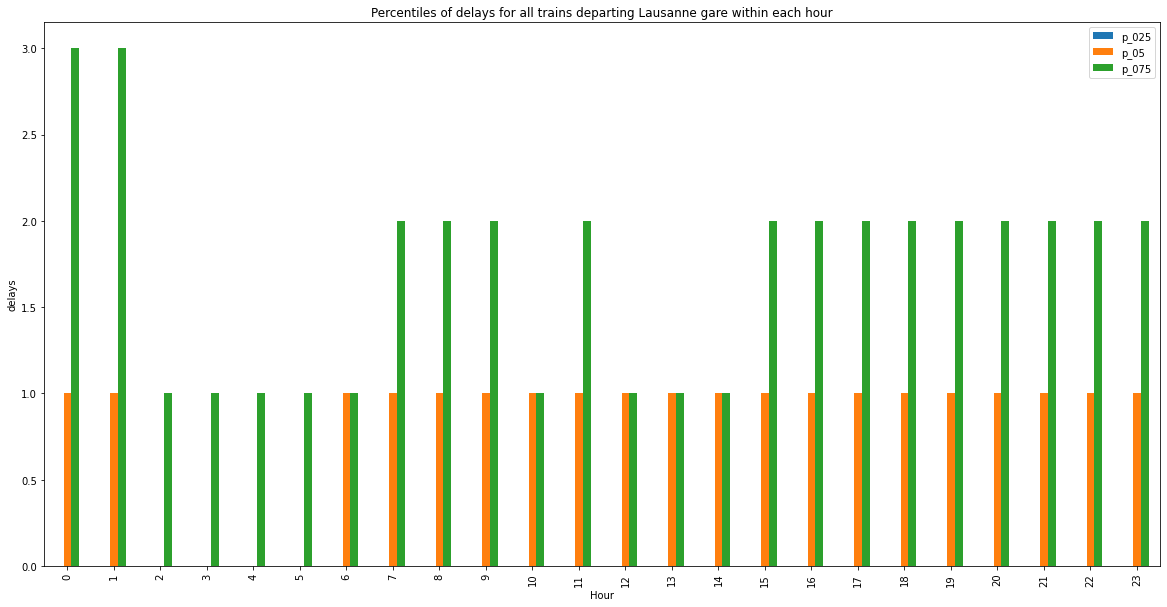

In [96]:
fig = df_lausanne_delays.plot.bar()
fig.set_title('Percentiles of delays for all trains departing Lausanne gare within each hour')
fig.set_ylabel('delays')
fig.set_xlabel('Hour')
plt.show()

***Observations:***

**We can see that the peaks are reached in the night, at 00:00 and 1 o'clock. In the morning we have most of the delays in the range of 2 minutes, between 7 and 9. Which can be interpreted by the flux of people going to work and the hustle of the mornings. This pattern can be seen between 15 and 23 too and on this periode people usually return home or go out. From 12 to 15, 75% of the delays are in the 1 minute range, it's lunch time and lunch break. What's more interesting is that the median of 1 minute is almost constant throughout day.**

iv) Did you notice something "strange"? Can you try to find the reasons behind that? Feel free to check it out from different perspectives.

**The strange thing is the peaks of delays at night. This may be intended as it'll be the last trains and people will maybe reach the station in delay. This interpretaion can be generalized for the after noon too. Maybe the trains are on time on the station but depart in delay so that people that have to change trains can catch the connection.**

### Question I.f - 15 Points

If the departure time of one train is delayed, can it catch up with the schedule at a later station? Select __at least 2 trains from Genève (main station) to Lausanne gare__ as examples. Think about what kind of trains you want to select, direct or indirect (having stops in between), at rush hour or in midnight? Use HiveQL to select relevant data and show the results with a proper plot of arrival delay at Lausanne versus departure delay at Genève. Document and discuss your findings.

__Note__: you can write some helper functions to generate the query for you.

In [4]:
def load_train(text, line):
    query = """
    drop table if exists {0}.{1}_{2}_lausanne
    """.format(username, text, line)
    cur.execute(query)

    query="""
    create table {0}.{1}_{2}_lausanne
    stored as ORC
    as
    select * from {0}.sbb_orc
    where LINIEN_ID = {2} and VERKEHRSMITTEL_TEXT = "{1}" and haltestellen_name = "Lausanne"
    """.format(username, text, line)
    cur.execute(query)

    query = """
    drop table if exists {0}.{1}_{2}_geneve
    """.format(username, text, line)
    cur.execute(query)

    query="""
    create table {0}.{1}_{2}_geneve
    stored as ORC
    as
    select * from {0}.sbb_orc
    where LINIEN_ID = {2} and VERKEHRSMITTEL_TEXT = "{1}" and lower(haltestellen_name) = "genève"
    """.format(username, text, line)
    cur.execute(query)

In [24]:
def train_table(text, line):
    query="""
        drop table if exists {0}.Times_L
    """.format(username, text, line)
    cur.execute(query)


    query="""
        CREATE TABLE {0}.Times_L as(
            select unix_timestamp(ankunftszeit, 'dd.MM.yyyy HH:mm') as expected_l, 
                   unix_timestamp(AN_PROGNOSE, 'dd.MM.yyyy HH:mm:ss') as actual_l,
                   betriebstag as dates
            from {0}.{1}_{2}_lausanne  
            where lower(AN_PROGNOSE_STATUS) like 'real' and ankunftszeit != '' 
        )
    """.format(username, text, line)
    cur.execute(query)

    query="""
        drop table if exists {0}.Times_G
       
    """.format(username, text, line)
    cur.execute(query)


    query="""
        CREATE TABLE {0}.Times_G as (
                select unix_timestamp(AB_PROGNOSE, 'dd.MM.yyyy HH:mm:ss') as actual_g,
                       unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyyy HH:mm') as expected_g, 
                       betriebstag as dates
                from {0}.{1}_{2}_geneve
                where lower(AB_PROGNOSE_STATUS) like 'real' and ABFAHRTSZEIT != ''  
            )
    
    
    """.format(username, text, line)
    cur.execute(query)
    
    query="""
        drop table if exists {0}.{1}_{2}_timedistrib
    """.format(username, text, line)
    cur.execute(query)


    query="""
        CREATE TABLE {0}.{1}_{2}_timedistrib as(
            select minute(from_unixtime( greatest(actual_l - expected_l, 0))) as delay_l,
               minute(from_unixtime( greatest(actual_g - expected_g, 0))) as delay_g,
               Times_G.dates
            from {0}.Times_L inner join {0}.Times_G on Times_L.dates = Times_G.dates
            where actual_g < actual_l
        )
    """.format(username, text, line)
    cur.execute(query)

In [28]:
def plot_delay(text, line):
    query="""
    select 
        avg(delay_l) as delay_l,
        delay_g
    from {0}.{1}_{2}_timedistrib
    group by delay_g
    limit 500
    """.format(username, text, line)
    df_type = pd.read_sql(query, conn)
    ax = df_type.plot.scatter(x='delay_g', y='delay_l', c='b')
    ax.plot(df_type['delay_g'], df_type['delay_g'], c="r")
    ax.set_title("Delay in Lausanne vs Delay in Genéve")
    ax.set_xlabel("Departure delay at Genéve")
    ax.set_ylabel("Arrival delay at Lausanne")
    return ax
    
    
    

The IC 733 goes from Geneve to Lausanne at peak hours and has almost no intermediary stops.

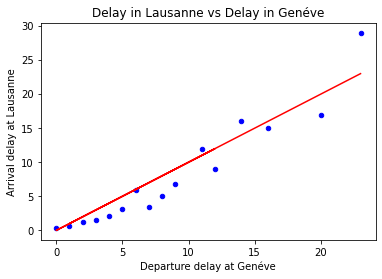

In [32]:
load_train("IC", "733")
train_table("IC", "733")
plot_delay("IC", "733")

As we can see the IC 733 only shaves of one to two minutes of delay. Longer delays do not change much.

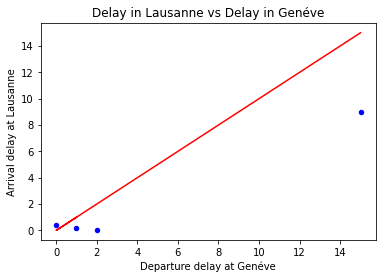

In [29]:
load_train("RE", "18401")
train_table("RE", "18401")
plot_delay("RE", "18401")

The train RE 18401 is almost never late and when it is it manages to catch up by as much as 4 minutes. This is expected for a train that is almost alone on the tracks at 3 am.

Let's look at the train RE 18445 which goes from Geneve to Lausanne at 15:20

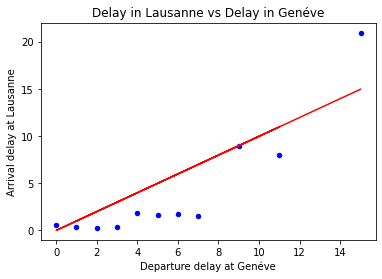

In [31]:
load_train("RE", "18445")
train_table("RE", "18445")
plot_delay("RE", "18445")